# MNIST digit recognition with convolutional neural network

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [18]:
print("Number of images in:")
print("- Training-data:\t{}".format(data.num_train))
print("- Validation-data:\t{}".format(data.num_val))
print("- Test-data:\t\t{}".format(data.num_test))

Number of images in:
- Training-data:	55000
- Validation-data:	5000
- Test-data:		10000


In [19]:
image_size = data.img_size
image_size_flat = data.img_size_flat
image_shape = data.img_shape
num_classes = data.num_classes
num_channels = data.num_channels
print(image_size,image_shape,num_classes,num_channels)

28 (28, 28) 10 1


In [24]:
def plot_images(image_data, label_true, label_pred=None):
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        pixels = image_data[i].reshape(image_shape)
        ax.imshow(pixels, cmap='binary')

        if label_pred is None:
            xlabel = "True: {0}".format(label_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(label_true[i], label_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

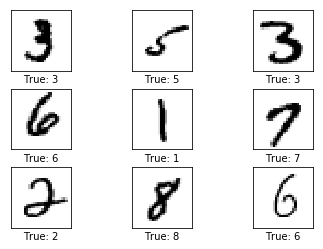

In [28]:
images = data.x_train[10:19]
label_true = data.y_train_cls[10:19]
plot_images(image_data=images, label_true=label_true)

In [81]:
def next_weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def next_bias(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_con_layer(input,               
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True):  # Use 2x2 max-pooling.


    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weight = next_weight(shape=shape)

    bias = next_bias(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weight,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += bias

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weight

def flatten_layer(layer):
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features
def new_fc_layer(input,          
                 num_inputs,    
                 num_outputs,    
                 use_relu=True): 

    weight = next_weight(shape=[num_inputs, num_outputs])
    bias = next_bias(length=num_outputs)

    layer = tf.matmul(input, weight) + bias

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [91]:
x = tf.placeholder(tf.float32, shape=[None, image_size_flat], name='x')
x_image = tf.reshape(x, [-1, image_size, image_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [ ]:
# Convolutional Layer 1.
filter_size1 = 5        
num_filters1 = 16       

# Convolutional Layer 2.
filter_size2 = 5          
num_filters2 = 36         

# Fully-connected layer.
fc_size = 128   

In [92]:
layer_conv1, weights_conv1 = \
    new_con_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu_4:0' shape=(?, 14, 14, 16) dtype=float32>

In [93]:
layer_conv2, weights_conv2 = \
    new_con_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [94]:
layer_conv2

<tf.Tensor 'Relu_5:0' shape=(?, 7, 7, 36) dtype=float32>

In [96]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_4:0' shape=(?, 1764) dtype=float32>

In [97]:
num_features

1764

In [99]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_6:0' shape=(?, 128) dtype=float32>

In [101]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_8:0' shape=(?, 10) dtype=float32>

In [103]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
accurate_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(accurate_prediction, tf.float32))

In [105]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64

In [106]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations

    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            print(msg.format(i + 1, acc))

    total_iterations += num_iterations

    end_time = time.time()

    time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [107]:
def plot_example_errors(cls_pred, correct):
    
    incorrect = (correct == False)
    
    images = data.x_test[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = data.y_test_cls[incorrect]
    
    plot_images(image_data=images[0:9],
                label_true=cls_true[0:9],
                label_pred=cls_pred[0:9])

In [108]:
def plot_confusion_matrix(label_pred):
    
    label_true = data.y_test_cls
    
    cm = confusion_matrix(y_true=label_true,
                          y_pred=label_pred)

    print(cm)

    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [109]:
# Split the test-set into batches.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = data.num_test

    label_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        
        j = min(i + test_batch_size, num_test)

        images = data.x_test[i:j, :]

        labels = data.y_test[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        label_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    label_true = data.y_test_cls

    correct = (label_true == label_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [111]:
#test accuracy before and after 1 iteration
print_test_accuracy()
optimize(num_iterations=1)
print_test_accuracy()

Accuracy on Test-Set: 8.0% (796 / 10000)
Optimization Iteration:      1, Training Accuracy:  17.2%
Time usage: 0:00:00
Accuracy on Test-Set: 9.0% (898 / 10000)


Time usage: 0:00:05
Accuracy on Test-Set: 65.6% (6565 / 10000)
Example errors:


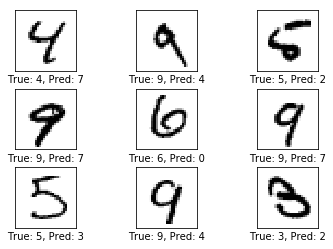

In [112]:
optimize(num_iterations=99) 
print_test_accuracy(show_example_errors=True)

Optimization Iteration:    101, Training Accuracy:  59.4%
Optimization Iteration:    201, Training Accuracy:  78.1%
Optimization Iteration:    301, Training Accuracy:  75.0%
Optimization Iteration:    401, Training Accuracy:  90.6%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  85.9%
Optimization Iteration:    701, Training Accuracy:  84.4%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  92.2%
Time usage: 0:00:46
Accuracy on Test-Set: 93.0% (9299 / 10000)
Example errors:


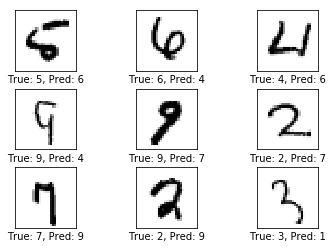

In [113]:
optimize(num_iterations=900) 
print_test_accuracy(show_example_errors=True)

Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy:  93.8%
Optimization Iteration:   1201, Training Accuracy:  84.4%
Optimization Iteration:   1301, Training Accuracy:  95.3%
Optimization Iteration:   1401, Training Accuracy:  92.2%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy:  92.2%
Optimization Iteration:   1801, Training Accuracy:  92.2%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I

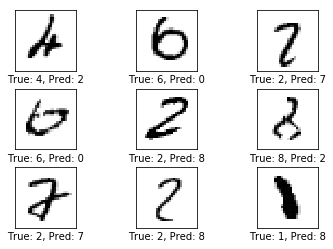

Confusion Matrix:
[[ 977    0    0    0    0    0    0    1    2    0]
 [   0 1129    1    0    0    0    2    0    3    0]
 [   1    2 1014    3    0    0    0    3    9    0]
 [   1    0    0 1003    0    4    0    1    1    0]
 [   0    0    2    0  974    0    1    2    0    3]
 [   2    0    0    4    0  881    3    1    1    0]
 [   4    3    0    1    2    5  943    0    0    0]
 [   0    1    6    5    0    0    0 1013    1    2]
 [   4    0    2    2    1    1    0    3  959    2]
 [   4    6    0    9    6    6    0    5    2  971]]


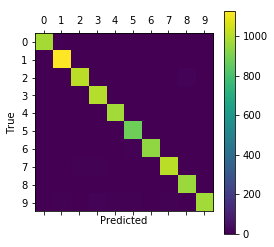

In [114]:
optimize(num_iterations=9000) 
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [85]:
def plot_con_weights(weight, input_channel=0):

    w = session.run(weight)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
        
            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [86]:
def plot_con_layer(layer, image):
    
    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
def plot_image(image):
    plt.imshow(image.reshape(image_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

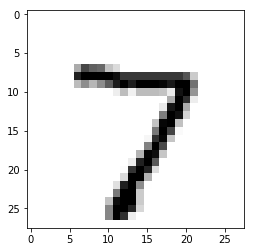

In [55]:
image = data.x_test[0]
plot_image(image)

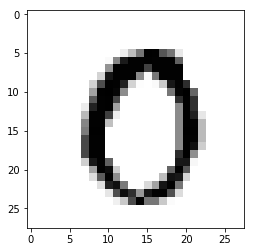

In [56]:
image = data.x_test[13]
plot_image(image)

### Convolution Layer 1

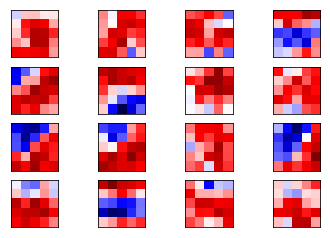

In [57]:
plot_con_weights(weight=weights_conv1)

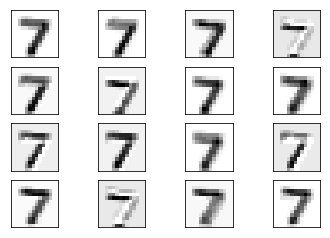

In [58]:
plot_con_layer(layer=layer_conv1, image=image1)

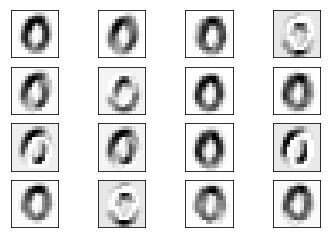

In [59]:
plot_con_layer(layer=layer_conv1, image=image2)

### Convolution Layer 2

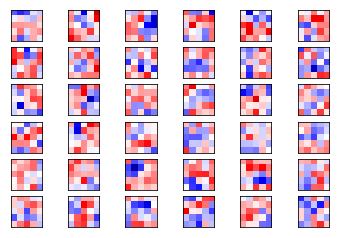

In [60]:
plot_con_weights(weight=weights_conv2, input_channel=0)

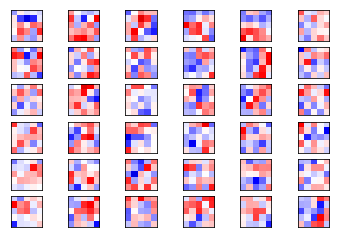

In [61]:
plot_con_weights(weight=weights_conv2, input_channel=1)

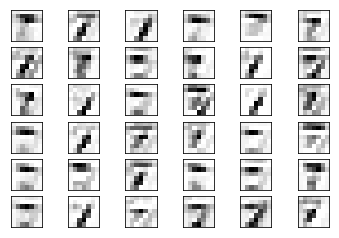

In [62]:
plot_con_layer(layer=layer_conv2, image=image1)

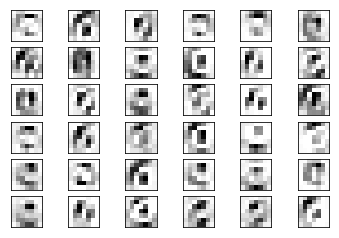

In [63]:
plot_conv_layer(layer=layer_conv2, image=image2)

The second convolutional layer seems to be able to detect lines and patterns. These have lower sensitivity local fluctuations and variations in the original input images.

In [64]:
session.close()